In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from random import seed,sample
import datetime as dt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler # Undersampling for Unbalanced Data
from imblearn.over_sampling import SMOTE # Oversampling for Unbalanced Data
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler # Data Encoders
from sklearn.model_selection import train_test_split
import scipy.stats as stats
from sklearn.ensemble import RandomForestClassifier
import networkx as nx

In [2]:
##fraudDataset.csv contains combined train.csv and test.csv data
df = pd.read_csv("C:/Users/sieji/OneDrive/Documents/NUS/BT4012/bt4012/fraudDataset.csv")
df = pd.concat([df[df["is_fraud"]==0].sample(frac=0.20, random_state=42), df[df["is_fraud"] == 1]])

In [3]:
df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
517683,2019-08-11 19:38:33,4681601008538160,fraud_Hermann and Sons,shopping_pos,50.81,Tammy,Davis,F,77663 Colleen Freeway,Moundsville,...,39.9148,-80.7310,16183,Physiotherapist,1977-08-12,f64003a5726ca99519ef2ad18bce32f5,1344713913,39.238053,-81.728984,0
1012042,2020-02-21 13:31:42,4653879239169997,"fraud_Cronin, Kshlerin and Weber",health_fitness,1.97,Monica,Tucker,F,302 Christina Islands,Smiths Grove,...,37.0581,-86.1938,6841,"Therapist, sports",1999-06-06,f8e25094098b22a8e9dce2670ffe891e,1361453502,36.665575,-85.608885,0
581404,2019-09-03 02:39:49,4334230547694630,fraud_Rutherford-Mertz,grocery_pos,100.18,Scott,Martin,M,7483 Navarro Flats,Freedom,...,43.0172,-111.0292,471,"Education officer, museum",1967-08-02,291160a410748e5bec42d95ae06132ae,1346639989,43.362578,-110.580382,0
1094893,2020-03-31 02:39:04,2256234701263057,fraud_Kris-Padberg,shopping_pos,7.67,Christopher,Grimes,M,39631 Dunn Radial,Grantham,...,43.5103,-72.1334,2971,Charity fundraiser,1948-04-11,df716fe9ce97522bc074d8c93e6e18c2,1364697544,44.312773,-71.555079,0
1729964,2020-12-05 07:58:57,6011948324228984,"fraud_Towne, Greenholt and Koepp",shopping_net,478.10,Mckenzie,Brooks,F,3872 Matthew Skyway,Paris,...,34.1992,-89.3820,297,"Administrator, local government",1961-12-14,c33bcd8c63d50b4fe9c2514c7107e1ba,1386230337,34.362314,-89.623306,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 378200 entries, 517683 to 1814246
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   trans_date_trans_time  378200 non-null  object 
 1   cc_num                 378200 non-null  int64  
 2   merchant               378200 non-null  object 
 3   category               378200 non-null  object 
 4   amt                    378200 non-null  float64
 5   first                  378200 non-null  object 
 6   last                   378200 non-null  object 
 7   gender                 378200 non-null  object 
 8   street                 378200 non-null  object 
 9   city                   378200 non-null  object 
 10  state                  378200 non-null  object 
 11  zip                    378200 non-null  int64  
 12  lat                    378200 non-null  float64
 13  long                   378200 non-null  float64
 14  city_pop               378200 non-n

In [5]:
total_rows = len(df)

fraud_count = df[df["is_fraud"] == 1]["is_fraud"].count()
non_fraud_count = df[df["is_fraud"] == 0]["is_fraud"].count()

fraud_proportion = fraud_count / total_rows
non_fraud_proportion = non_fraud_count / total_rows

print("Proportion of Fraudulent Transactions:", fraud_proportion)
print("Proportion of Non-Fraudulent Transactions:", non_fraud_proportion)


Proportion of Fraudulent Transactions: 0.025518244315177154
Proportion of Non-Fraudulent Transactions: 0.9744817556848229


In [6]:

#dual classification graph creation function
def build_graph_bipartite(df_input, graph_type=nx.Graph()):
    df = df_input.copy()
    
    # Create graph nodes by mapping unique credit card numbers and merchant IDs
    mapping = {x:node_id for node_id,x in enumerate(set(df["cc_num"].values.tolist() + df["merchant"].values.tolist()))}
    df["from"] = df["cc_num"].apply(lambda x: mapping[x])
    df["to"] = df["merchant"].apply(lambda x: mapping[x])
    
    #Group by 'from', 'to', 'amt', 'is_fraud' columns and calculate sum
    df = df[['from', 'to', "amt", "is_fraud"]].groupby(['from', 'to']).agg({"is_fraud": "sum", "amt": "sum"}).reset_index()
    
    #Convert 'is_fraud' column to 0 and 1
    df["is_fraud"] = df["is_fraud"].apply(lambda x: 1 if x>0 else 0)
    
    #Graph creation
    G = nx.from_edgelist(df[["from", "to"]].values, create_using=graph_type)
    
    #Node property settings
    nx.set_node_attributes(G,{x:1 for x in df["from"].unique()}, "bipartite")
    nx.set_node_attributes(G,{x:2 for x in df["to"].unique()}, "bipartite")
    
    #Edge label settings
    nx.set_edge_attributes(G, 
                       {(int(x["from"]), int(x["to"])):x["is_fraud"] for idx, x in df[["from","to","is_fraud"]].iterrows()}, 
                       "label")

    #Edge weight settings
    nx.set_edge_attributes(G, 
                       {(int(x["from"]), int(x["to"])):x["amt"] for idx, x in df[["from","to","amt"]].iterrows()}, 
                       "weight")
    return G

#Triple classification graph creation function
def build_graph_tripartite(df_input, graph_type=nx.Graph()):
    df = df_input.copy()
    
    mapping = {x:node_id for node_id,x in enumerate(set(df.index.values.tolist() + 
                                                        df["cc_num"].values.tolist() + 
                                                        df["merchant"].values.tolist()))}
    df["in_node"] = df["cc_num"].apply(lambda x: mapping[x])
    df["out_node"] = df["merchant"].apply(lambda x: mapping[x])

    G = nx.from_edgelist([(x["in_node"], mapping[idx]) for idx, x in df.iterrows()] +
                         [(x["out_node"], mapping[idx]) for idx, x in df.iterrows()], 
                         create_using=graph_type)

    nx.set_node_attributes(G,{x["in_node"]:1 for idx,x in df.iterrows()}, "bipartite")
    nx.set_node_attributes(G,{x["out_node"]:2 for idx,x in df.iterrows()}, "bipartite")
    nx.set_node_attributes(G,{mapping[idx]:3 for idx, x in df.iterrows()}, "bipartite")

    nx.set_edge_attributes(G,{(x["in_node"], mapping[idx]):x["is_fraud"] for idx, x in df.iterrows()}, "label")
    nx.set_edge_attributes(G,{(x["out_node"], mapping[idx]):x["is_fraud"] for idx, x in df.iterrows()}, "label")

    nx.set_edge_attributes(G,{(x["in_node"], mapping[idx]):x["amt"] for idx, x in df.iterrows()}, "weight")
    nx.set_edge_attributes(G,{(x["out_node"], mapping[idx]):x["amt"] for idx, x in df.iterrows()}, "weight")
    return G

Build the Bipartite and Tripartite graphs

In [7]:
G_bu = build_graph_bipartite(df, nx.Graph(name = 'Bipartite Undirected'))
G_bd = build_graph_bipartite(df, nx.DiGraph(name = 'Bipartite Directed'))
G_tu = build_graph_tripartite(df, nx.Graph(name = 'Bipartite Undirected'))
G_td = build_graph_tripartite(df, nx.DiGraph(name='Tripartite Directed'))

In [8]:
from networkx.algorithms import bipartite
bipartite.is_bipartite(G_bu)

True

In [9]:

def print_graph_info(graph):
    num_nodes = len(graph.nodes)
    num_edges = len(graph.edges)
    graph_density = num_edges / (num_nodes * (num_nodes - 1) / 2)  # If the graph is undirected
    average_degree = sum(dict(graph.degree()).values()) / num_nodes

    print("Number of nodes:", num_nodes)
    print("Number of edges:", num_edges)
    print("Graph density:", graph_density)
    print("Average degree:", average_degree)
    print("Number of nodes:", num_nodes)
    
print_graph_info(G_bu)


Number of nodes: 1692
Number of edges: 259950
Graph density: 0.18170875431466546
Average degree: 307.2695035460993
Number of nodes: 1692


In [10]:
print_graph_info(G_tu)

Number of nodes: 379892
Number of edges: 756400
Graph density: 1.0482439463704292e-05
Average degree: 3.982184410306087
Number of nodes: 379892


Plotting distribution of node degrees for both graph structures

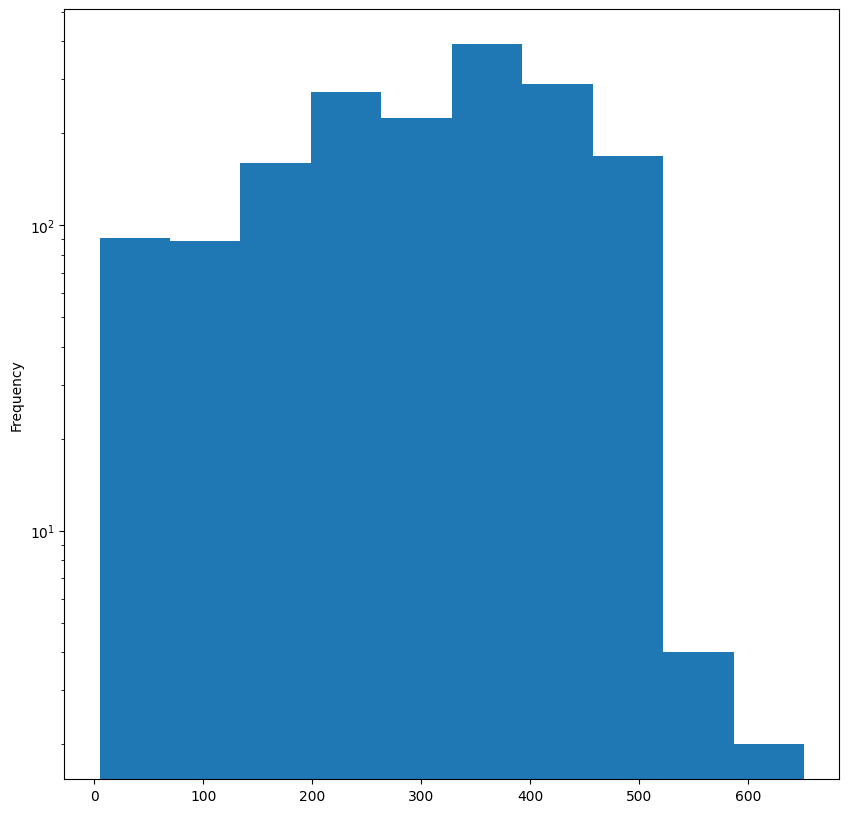

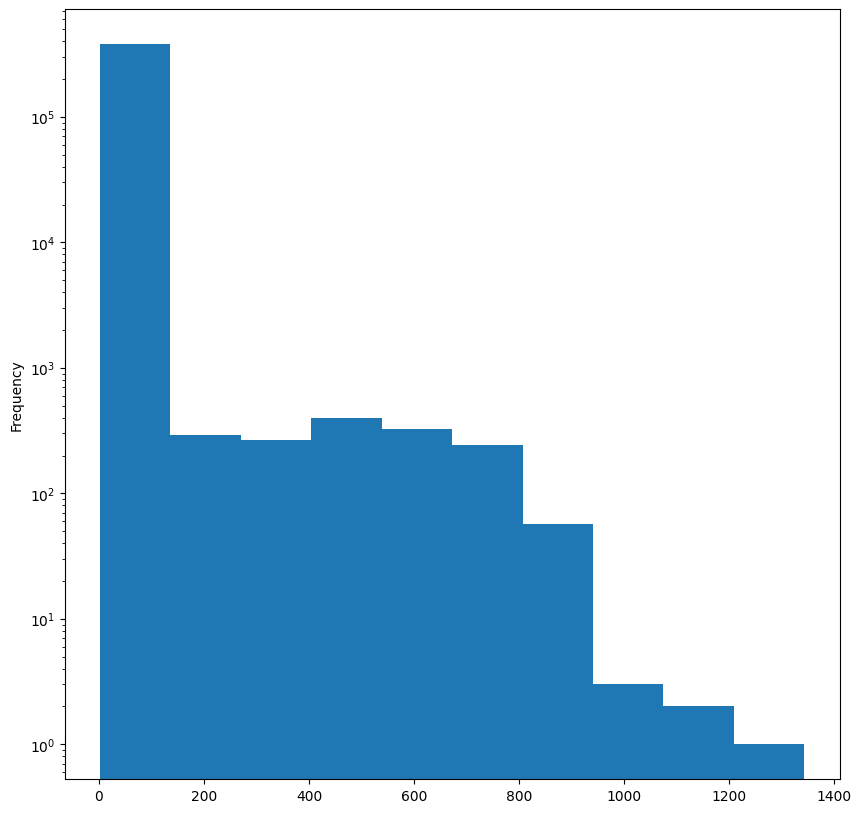

In [11]:
for G in [G_bu, G_tu]:
    plt.figure(figsize=(10,10))
    degrees = pd.Series(
        {
            k:v for k,v in nx.degree(G)
        }
    )
    degrees.plot.hist()
    plt.yscale("log")

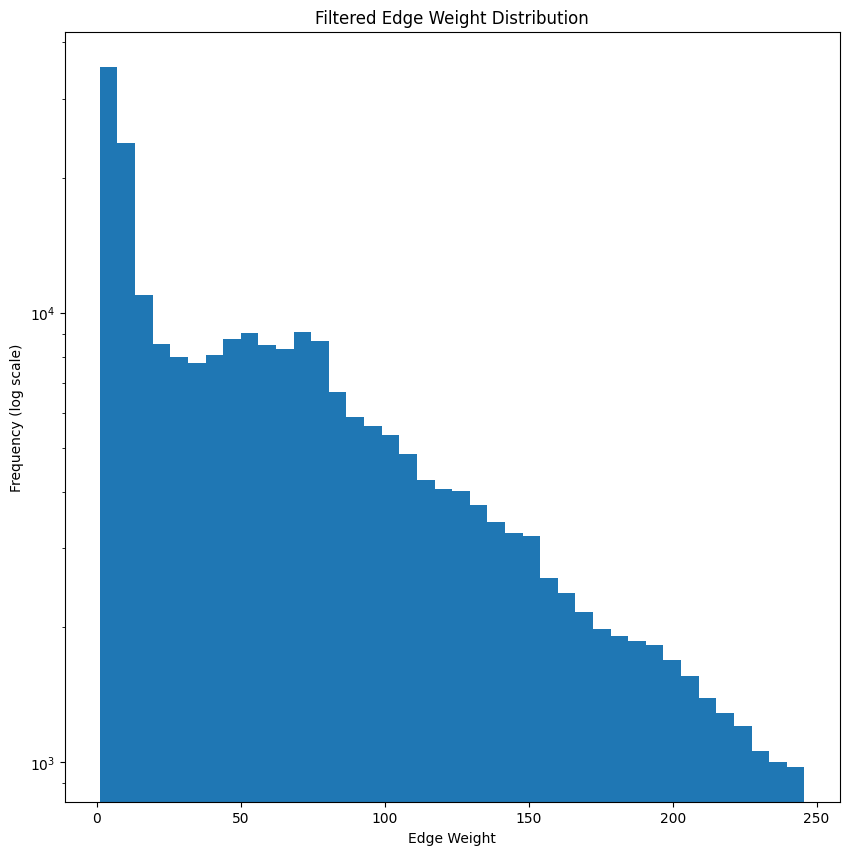

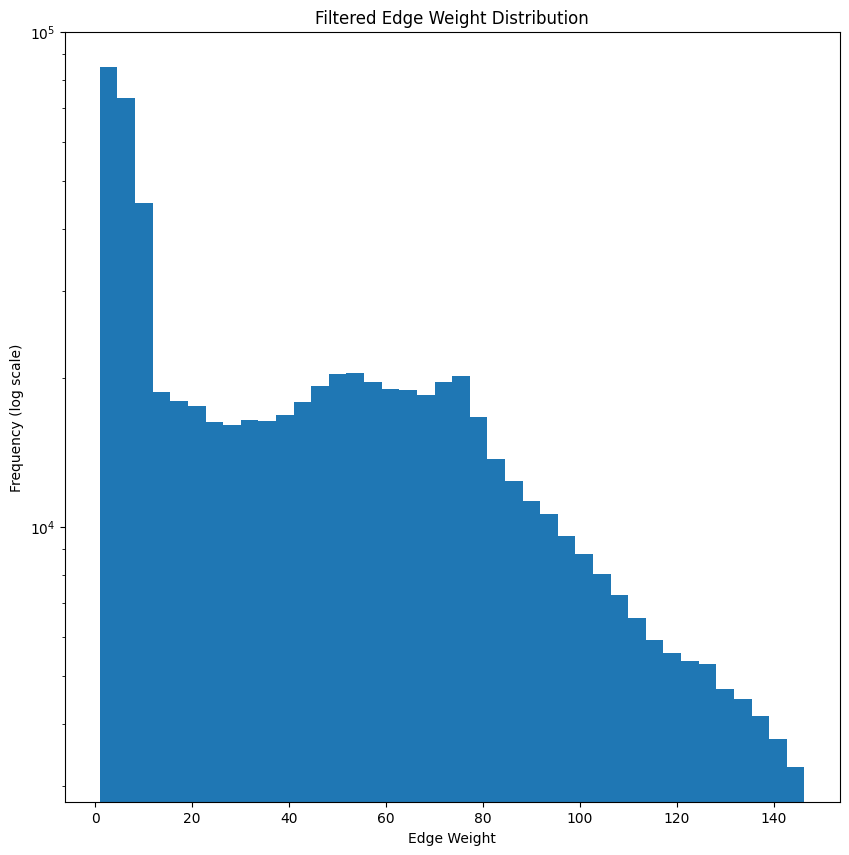

In [12]:
graph_list = [G_bu, G_tu]

for G in graph_list:
    all_edge_weights = pd.Series({(d[0], d[1]): d[2]["weight"] for d in G.edges(data=True)})
    
    quantiles = np.quantile(all_edge_weights.values, [0.10, 0.50, 0.70, 0.9, 1.0])
    
    quant_dist = np.quantile(all_edge_weights.values, [0.10, 0.50, 0.70, 0.9])
    
    all_edge_weights_filtered = pd.Series({(d[0], d[1]): d[2]["weight"] for d in G.edges(data=True) if d[2]["weight"] < quant_dist[-1]})
    
    plt.figure(figsize=(10, 10))
    all_edge_weights_filtered.plot.hist(bins=40)
    plt.yscale("log")
    plt.xlabel('Edge Weight')
    plt.ylabel('Frequency (log scale)')
    plt.title('Filtered Edge Weight Distribution')
    plt.show()


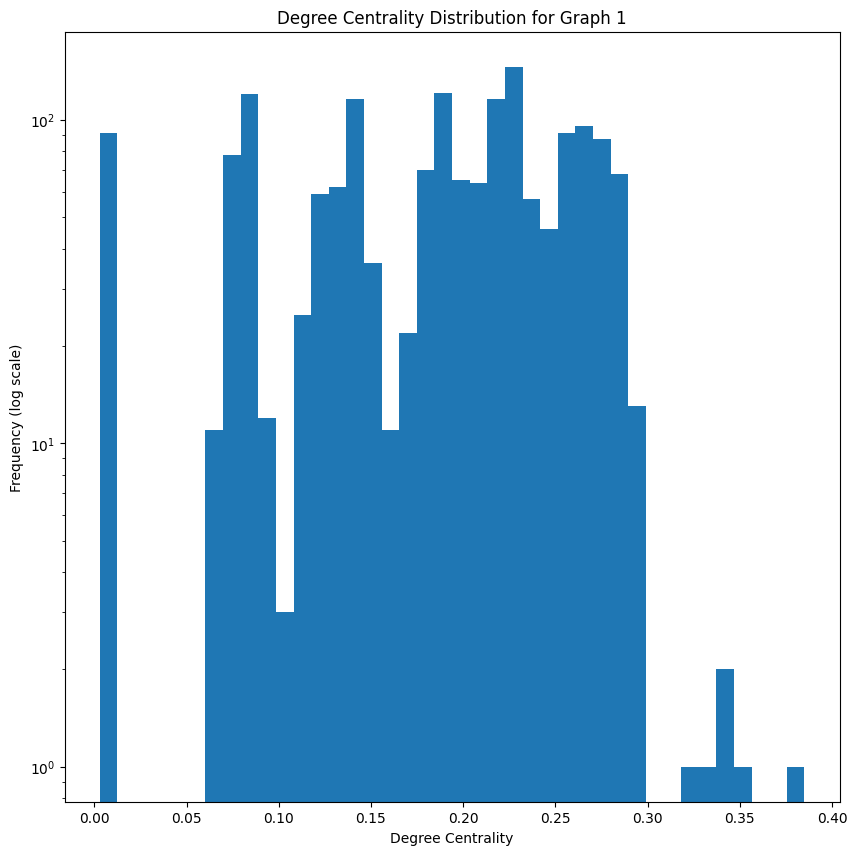

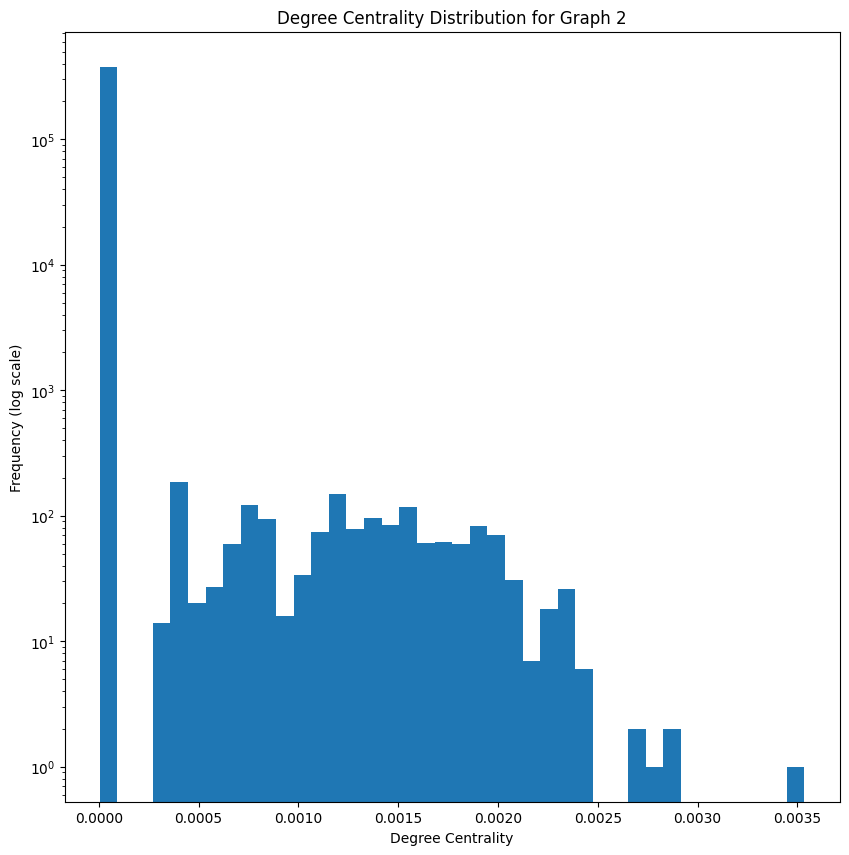

In [13]:
graph_list = [G_bu, G_tu]

degree_centrality_results = {}

for i, G in enumerate(graph_list):
    degree_centrality = nx.degree_centrality(G)
    
    degree_centrality_series = pd.Series(degree_centrality)
    
    plt.figure(figsize=(10, 10))
    degree_centrality_series.plot.hist(bins=40)
    plt.yscale("log")
    plt.xlabel('Degree Centrality')
    plt.ylabel('Frequency (log scale)')
    plt.title(f'Degree Centrality Distribution for Graph {i + 1}')
    plt.show()

In [14]:
import community
parts = community.best_partition(G_bu, random_state=42, weight='weight')
communities = pd.Series(parts)
communities.value_counts().sort_values(ascending=False)

2     477
1     310
3     285
7     120
5     117
0      92
4      77
8      65
13     43
10     38
11     35
12     19
6      11
9       3
Name: count, dtype: int64

The results indicate that the network can be partitioned into 18 distinct communities. These communities vary in size, with the largest community having 170 nodes and the smallest having 21 nodes. The varying sizes suggest that some groups of nodes are more tightly connected or influential than others within the network

<Axes: ylabel='Frequency'>

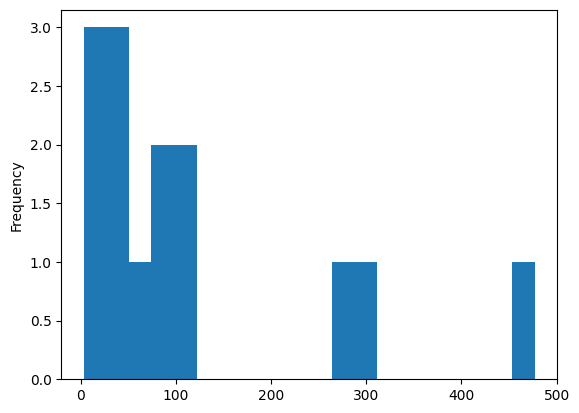

In [15]:
communities.value_counts().plot.hist(bins=20)

In [16]:
community_ratios = {}

for community_id in communities.unique():
    subgraph = nx.subgraph(G_bu, communities[communities == community_id].index)
    total_edges = subgraph.number_of_edges()
    fraud_edges = sum(nx.get_edge_attributes(subgraph, "label").values())

    ratio = 0 if total_edges == 0 else (fraud_edges / total_edges) * 100
    community_ratios[community_id] = ratio
pd.Series(community_ratios).sort_values(ascending=False)


11    21.052632
13    20.879121
7     20.178372
4     17.532468
0     16.519174
5     15.845824
10    15.217391
12    14.705882
8     11.086957
3      6.120700
2      2.621598
1      1.853077
6      0.000000
9      0.000000
dtype: float64

The above is the fraudulent percentage provided at the community level. We can further plot the node-induced subgraphs for a particular community. In the code below, gId indicates the Community ID.

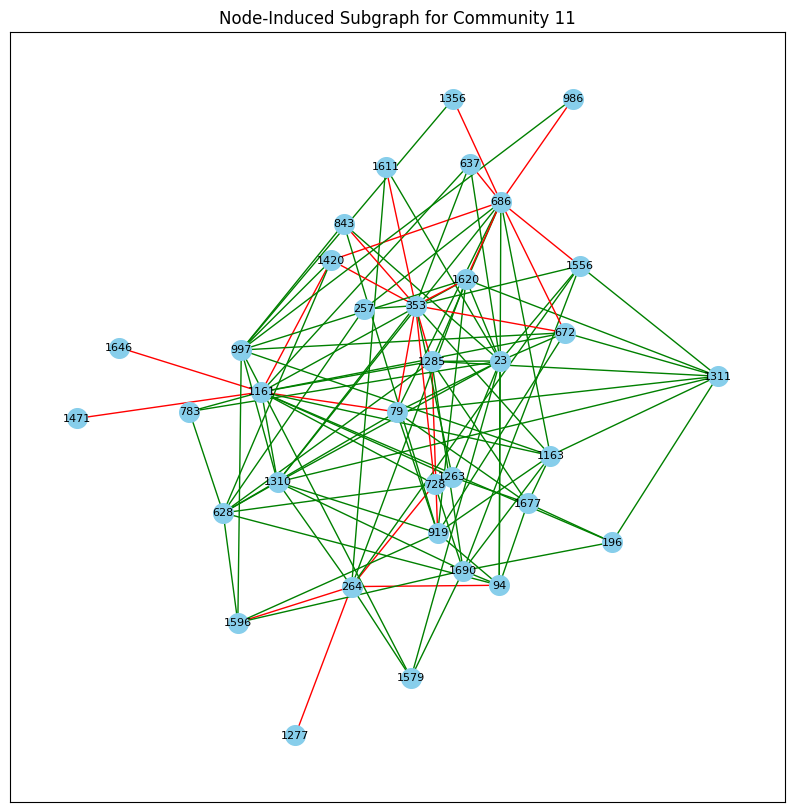

In [17]:
def plot_community_subgraph(graph, community_id):
    subgraph = nx.subgraph(graph, communities[communities == community_id].index)
    
    edge_colors = ["green" if subgraph.edges[edge]["label"] == 0 else "red" for edge in subgraph.edges()]

    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(subgraph, seed=42)  # You can use different layout algorithms

    nx.draw_networkx_nodes(subgraph, pos, node_size=200, node_color="skyblue")
    nx.draw_networkx_labels(subgraph, pos, font_size=8)

    nx.draw_networkx_edges(subgraph, pos, width=1, edge_color=edge_colors)

    plt.title(f"Node-Induced Subgraph for Community {community_id}")
    plt.show()

plot_community_subgraph(G_bu, community_id=11)

Even though community 11 had the highest percentage of fraud transactions, it seems the volume density is little. Let us plot the community with the second highest percentage.

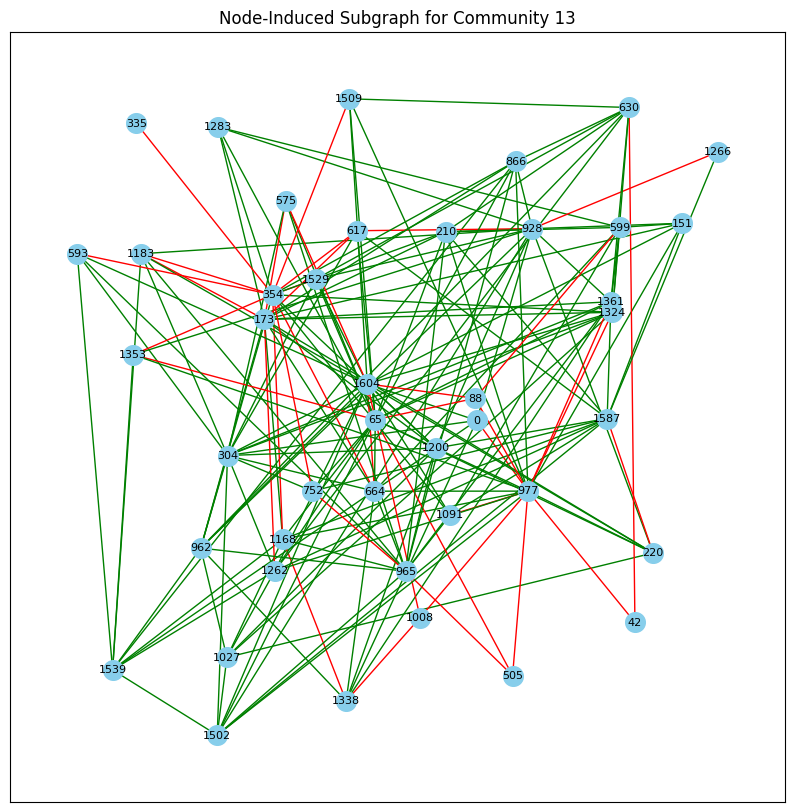

In [18]:
plot_community_subgraph(G_bu, community_id=13)


Community 9 seems more dense

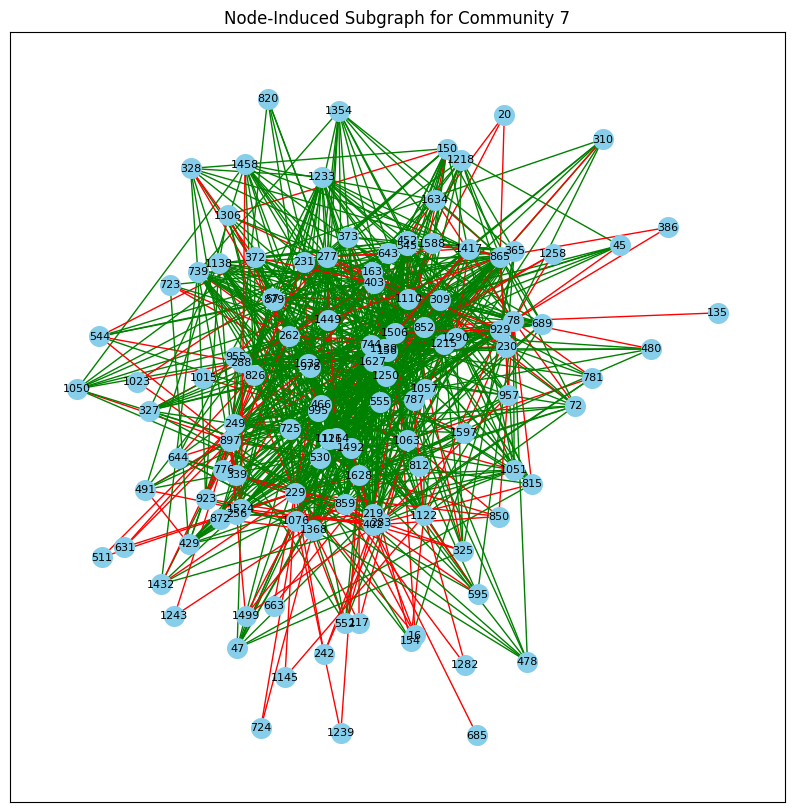

In [19]:
plot_community_subgraph(G_bu, community_id=7)

Community 10 contains the densest graph with many intersecting edges and nodes.

Now, we will plot for the community with the least fraud percentage

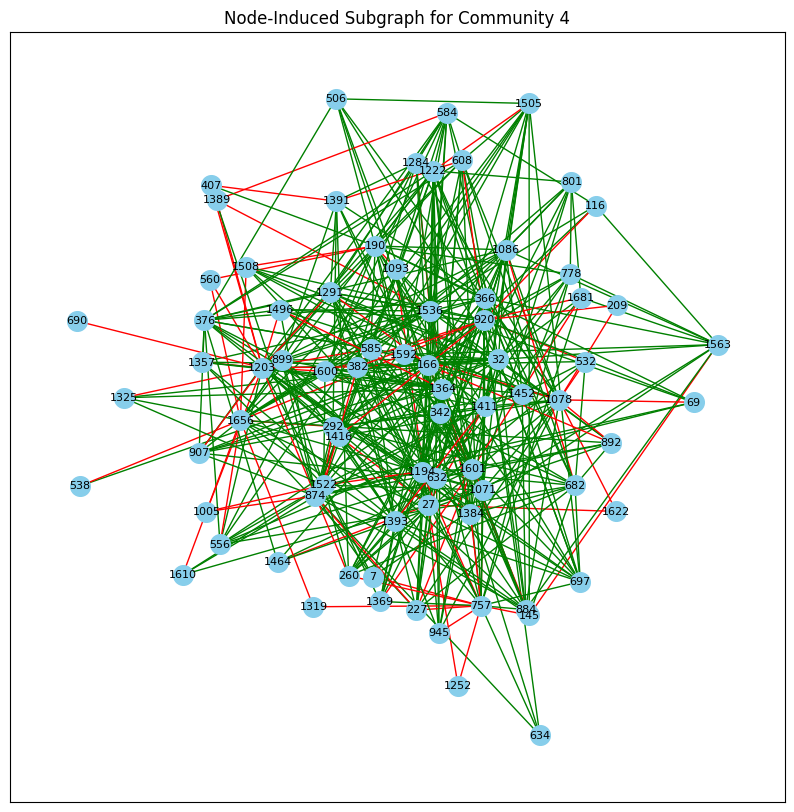

In [20]:
plot_community_subgraph(G_bu, community_id=4)

Handling Class Imbalance:
In order to build a random forest model, which can be computationally intensive, we will create a downsampled df with equal instances of both fraud and non-fraud classes. This saves time and resources when building the model.

In [21]:
from sklearn.utils import resample

df_majority = df[df.is_fraud == 0]
df_minority = df[df.is_fraud == 1]

num_samples = len(df_minority)

df_maj_downsampled = resample(df_majority, n_samples=num_samples, random_state=42)

df_downsampled = pd.concat([df_minority, df_maj_downsampled])

print(df_downsampled.is_fraud.value_counts())

G_down = build_graph_bipartite(df_downsampled)

is_fraud
1    9651
0    9651
Name: count, dtype: int64


Performing Train Test Split

In [22]:
from sklearn.model_selection import train_test_split

train_edges, temp_edges, train_labels, temp_labels = train_test_split(list(range(len(G_down.edges))),
                                                                      list(nx.get_edge_attributes(G_down, "label").values()),
                                                                      test_size = 0.20,
                                                                      random_state=42)

val_edges, test_edges, val_labels, test_labels = train_test_split(temp_edges, temp_labels, test_size=0.5, random_state=42)

In [23]:
edgs = list(G_down.edges)

train_graph = G_down.edge_subgraph([edgs[x] for x in train_edges]).copy()

train_graph.add_nodes_from(set(G_down.nodes) - set(train_graph.nodes))


In [24]:
from node2vec import Node2Vec

node2vec_train = Node2Vec(train_graph, weight_key='weight')
model_train = node2vec_train.fit(window=10)

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:10<00:00,  1.05s/it]


In [27]:
from sklearn.ensemble import RandomForestClassifier
from node2vec.edges import HadamardEmbedder, AverageEmbedder, WeightedL1Embedder, WeightedL2Embedder
from sklearn import metrics

embedding_classes = [HadamardEmbedder, AverageEmbedder, WeightedL1Embedder, WeightedL2Embedder]
results = []
for embedding_class in embedding_classes:
    embeddings_train = embedding_class(keyed_vectors=model_train.wv)
    train_embeddings = [embeddings_train[str(edgs[x][0]), str(edgs[x][1])] for x in train_edges]
    val_embeddings = [embeddings_train[str(edgs[x][0]), str(edgs[x][1])] for x in val_edges]
    
    rf_classifier = RandomForestClassifier(n_estimators=1000, random_state=42)
    rf_classifier.fit(train_embeddings, train_labels)

    y_pred = rf_classifier.predict(val_embeddings)
    precision = metrics.precision_score(val_labels, y_pred)
    recall = metrics.recall_score(val_labels, y_pred)
    f1 = metrics.f1_score(val_labels, y_pred)
    auc = metrics.roc_auc_score(val_labels, y_pred)

    results.append({
        'Embedding_Class': embedding_class.__name__,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc
    })

results_df = pd.DataFrame(results)
print(results_df)

      Embedding_Class  Precision    Recall  F1-Score       AUC
0    HadamardEmbedder   0.555556  0.010363  0.020346  0.500805
1     AverageEmbedder   0.724010  0.606218  0.659898  0.681118
2  WeightedL1Embedder   0.606061  0.020725  0.040080  0.503251
3  WeightedL2Embedder   0.571429  0.020725  0.040000  0.502157


It seems the Average Embedding method gives  the best evaluation metric scores with 70.1% AUC. We will now improve the perfomance metrics by doing hyperparamater tuning

In [28]:
embedding_method = AverageEmbedder(keyed_vectors=model_train.wv)

# Create training and testing embeddings
train_embeddings = [embedding_method[str(edgs[x][0]), str(edgs[x][1])] for x in train_edges]
val_embeddings = [embedding_method[str(edgs[x][0]), str(edgs[x][1])] for x in val_edges]
test_embeddings = [embedding_method[str(edgs[x][0]), str(edgs[x][1])] for x in test_edges]
train_embeddings_np = np.array(train_embeddings)
val_embeddings_np = np.array(val_embeddings)
test_embeddings = np.array(test_embeddings)
test_embeddings_np = np.array(test_embeddings)

train_labels_np = np.array(train_labels)
val_labels_np = np.array(val_labels)
test_labels_np = np.array(test_labels)

Training RandomForest model

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, average_precision_score

# Assuming you have train_embeddings_np, val_embeddings_np, train_labels_np, val_labels_np defined

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(train_embeddings_np, train_labels_np)

y_pred_prob_rf = rf_classifier.predict_proba(val_embeddings_np)[:, 1]

y_pred_binary_rf = (y_pred_prob_rf > 0.5).astype(int)

precision_rf = precision_score(val_labels_np, y_pred_binary_rf)
recall_rf = recall_score(val_labels_np, y_pred_binary_rf)
f1_rf = f1_score(val_labels_np, y_pred_binary_rf)
pr_auc_rf = average_precision_score(val_labels_np, y_pred_prob_rf)
roc_auc_rf = roc_auc_score(val_labels_np, y_pred_prob_rf)
model_name = 'Random Forest'

new_row_rf = {
    'Model': model_name,
    'Precision': precision_rf,
    'Recall': recall_rf,
    'F1 Score': f1_rf,
    'PR AUC': pr_auc_rf,
    'ROC AUC': roc_auc_rf
}

Saving results in separate DF to be displayed at the end for comparison.

In [31]:
if 'final_results' not in locals():
    final_results = pd.DataFrame(columns=['Model', 'Precision', 'Recall', 'F1 Score', 'PR AUC', 'ROC AUC'])

model_name = 'Random Forest'  # Update with the relevant model name

new_row = {'Model': model_name, 'Precision': precision_rf, 'Recall': recall_rf, 'F1 Score': f1_rf, 'PR AUC': pr_auc_rf, 'ROC AUC': roc_auc_rf}
final_results = pd.concat([final_results, pd.DataFrame([new_row])], ignore_index=True)


Building XGBoost model now

In [33]:
import xgboost as xgb
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, average_precision_score

xgb_classifier = xgb.XGBClassifier(
    objective='binary:logistic',
    learning_rate=0.1,
    max_depth=6,
    n_estimators=100,
    eval_metric='logloss'
)

xgb_classifier.fit(train_embeddings_np, train_labels_np)

y_pred_prob_xgb = xgb_classifier.predict_proba(val_embeddings_np)[:, 1]

y_pred_binary_xgb = (y_pred_prob_xgb > 0.5).astype(int)

precision_xgb = precision_score(val_labels_np, y_pred_binary_xgb)
recall_xgb = recall_score(val_labels_np, y_pred_binary_xgb)
f1_xgb = f1_score(val_labels_np, y_pred_binary_xgb)
pr_auc_xgb = average_precision_score(val_labels_np, y_pred_prob_xgb)
roc_auc_xgb = roc_auc_score(val_labels_np, y_pred_prob_xgb)
model_name = 'XGBoost'

new_row2 = {'Model': model_name, 'Precision': precision_xgb, 'Recall': recall_xgb, 'F1 Score': f1_xgb, 'PR AUC': pr_auc_xgb, 'ROC AUC': roc_auc_xgb}


In [34]:
final_results = pd.concat([final_results, pd.DataFrame([new_row2])], ignore_index=True)
final_results

,Model,Precision,Recall,F1 Score,PR AUC,ROC AUC
0,Random Forest,0.681319,0.578238,0.625561,0.693435,0.684621
1,XGBoost,0.697842,0.502591,0.584337,0.703531,0.683234


Building Catboost Model now

In [35]:
from catboost import CatBoostClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score, roc_auc_score

catboost_classifier = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6, random_seed=42)

catboost_classifier.fit(train_embeddings_np, train_labels_np, eval_set=(val_embeddings_np, val_labels_np))

y_pred_prob = catboost_classifier.predict_proba(val_embeddings_np)[:, 1]

0:	learn: 0.6903538	test: 0.6912836	best: 0.6912836 (0)	total: 182ms	remaining: 18s
1:	learn: 0.6875380	test: 0.6897771	best: 0.6897771 (1)	total: 202ms	remaining: 9.88s
2:	learn: 0.6849104	test: 0.6883079	best: 0.6883079 (2)	total: 223ms	remaining: 7.2s
3:	learn: 0.6821695	test: 0.6860506	best: 0.6860506 (3)	total: 242ms	remaining: 5.8s
4:	learn: 0.6796329	test: 0.6844034	best: 0.6844034 (4)	total: 261ms	remaining: 4.95s
5:	learn: 0.6772435	test: 0.6824382	best: 0.6824382 (5)	total: 279ms	remaining: 4.36s
6:	learn: 0.6748242	test: 0.6813881	best: 0.6813881 (6)	total: 299ms	remaining: 3.97s
7:	learn: 0.6726984	test: 0.6804462	best: 0.6804462 (7)	total: 317ms	remaining: 3.65s
8:	learn: 0.6707853	test: 0.6795484	best: 0.6795484 (8)	total: 336ms	remaining: 3.4s
9:	learn: 0.6688002	test: 0.6781338	best: 0.6781338 (9)	total: 354ms	remaining: 3.19s
10:	learn: 0.6671345	test: 0.6775309	best: 0.6775309 (10)	total: 373ms	remaining: 3.02s
11:	learn: 0.6650236	test: 0.6770129	best: 0.6770129 (11)

In [36]:
precision_cb = precision_score(val_labels_np, y_pred_prob > 0.5)
recall_cb = recall_score(val_labels_np, y_pred_prob > 0.5)
f1_cb = f1_score(val_labels_np, y_pred_prob > 0.5)
pr_auc_cb = average_precision_score(val_labels_np, y_pred_prob)
roc_auc_cb = roc_auc_score(val_labels_np, y_pred_prob)
model_name = 'Catboost'
new_row3 = {'Model': model_name, 'Precision': precision_cb, 'Recall': recall_cb, 'F1 Score': f1_cb, 'PR AUC': pr_auc_cb, 'ROC AUC': roc_auc_cb}

final_results = pd.concat([final_results, pd.DataFrame([new_row3])], ignore_index=True)
final_results

,Model,Precision,Recall,F1 Score,PR AUC,ROC AUC
0,Random Forest,0.681319,0.578238,0.625561,0.693435,0.684621
1,XGBoost,0.697842,0.502591,0.584337,0.703531,0.683234
2,Catboost,0.663934,0.587565,0.623419,0.683489,0.674108


Building Adaboost now

In [37]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score, roc_auc_score

ada_classifier = AdaBoostClassifier(n_estimators=50, random_state=42)

ada_classifier.fit(train_embeddings_np, train_labels_np)

y_pred_prob = ada_classifier.predict_proba(val_embeddings_np)[:, 1]


In [38]:
precision_ab = precision_score(val_labels_np, y_pred_prob > 0.5)
recall_ab = recall_score(val_labels_np, y_pred_prob > 0.5)
f1_ab = f1_score(val_labels_np, y_pred_prob > 0.5)
pr_auc_ab = average_precision_score(val_labels_np, y_pred_prob)
roc_auc_ab = roc_auc_score(val_labels_np, y_pred_prob)
model_name = 'Adaboost'
new_row4 = {'Model': model_name, 'Precision': precision_ab, 'Recall': recall_ab, 'F1 Score': f1_ab, 'PR AUC': pr_auc_ab, 'ROC AUC': roc_auc_ab}

final_results = pd.concat([final_results, pd.DataFrame([new_row4])], ignore_index=True)
final_results

,Model,Precision,Recall,F1 Score,PR AUC,ROC AUC
0,Random Forest,0.681319,0.578238,0.625561,0.693435,0.684621
1,XGBoost,0.697842,0.502591,0.584337,0.703531,0.683234
2,Catboost,0.663934,0.587565,0.623419,0.683489,0.674108
3,Adaboost,0.620892,0.548187,0.582278,0.644404,0.636320


Random Forest seems to be the best model, as it has in general the best metric across the board. We will now proceed to tune the Random Forest to get best possible results

Performing hyperparameter tuning on Random Forest model.

In [40]:
from sklearn.ensemble import RandomForestClassifier
from node2vec.edges import AverageEmbedder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

embedding_method = AverageEmbedder(keyed_vectors=model_train.wv)

train_embeddings = [embedding_method[str(edgs[x][0]), str(edgs[x][1])] for x in train_edges]
val_embeddings = [embedding_method[str(edgs[x][0]), str(edgs[x][1])] for x in val_edges]

param_grid = {
    'n_estimators': [100, 500], 
    'max_depth': [None, 10],
    'min_samples_split': [2, 5], 
    'min_samples_leaf': [1]
}

rf_classifier = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(rf_classifier, param_grid, scoring='f1', cv=5)

grid_search.fit(train_embeddings, train_labels)

best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

best_rf_classifier = grid_search.best_estimator_
y_pred_prob = best_rf_classifier.predict_proba(val_embeddings)[:, 1]


Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}


In [41]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, average_precision_score

# Assuming you have val_labels as the true labels for the validation set

# Predict probabilities on the validation set
y_pred_prob = best_rf_classifier.predict_proba(test_embeddings)[:, 1]

# Convert probabilities to binary predictions using a threshold (0.5 for binary classification)
y_pred_binary = (y_pred_prob > 0.5).astype(int)

# Calculate metrics
precision = precision_score(test_labels, y_pred_binary)
recall = recall_score(test_labels, y_pred_binary)
f1 = f1_score(test_labels, y_pred_binary)
pr_auc = average_precision_score(test_labels, y_pred_prob)
roc_auc = roc_auc_score(test_labels, y_pred_prob)

# Display the metrics
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"PR AUC: {pr_auc}")
print(f"ROC AUC: {roc_auc}")


Precision: 0.7248062015503876
Recall: 0.6051779935275081
F1 Score: 0.6596119929453262
PR AUC: 0.7321408705449006
ROC AUC: 0.7420867214199595
